In [1]:
import osmnx as ox
ox.config(log_console = True, use_cache = True)
ox.__version__
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import networkx as nx
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline

In [2]:
Miami = "Miami, Florida, US"

In [3]:
network_type = 'walk'
trip_times = [5, 15, 25, 35, 40, 45]
travel_speed = 7.5
fast_pace_travel_speed = 15.8

In [4]:
Miami_streets = ox.graph_from_place(Miami, network_type=network_type)

In [5]:
Miami_nodes = ox.graph_to_gdfs(Miami_streets, edges=False)
x, y = Miami_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(Miami_streets, (y[0], x[0]))
Miami_streets = ox.project_graph(Miami_streets)

In [6]:
meters_per_minute = travel_speed * 1000 / 60
for u, v, k, data in Miami_streets.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [7]:
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

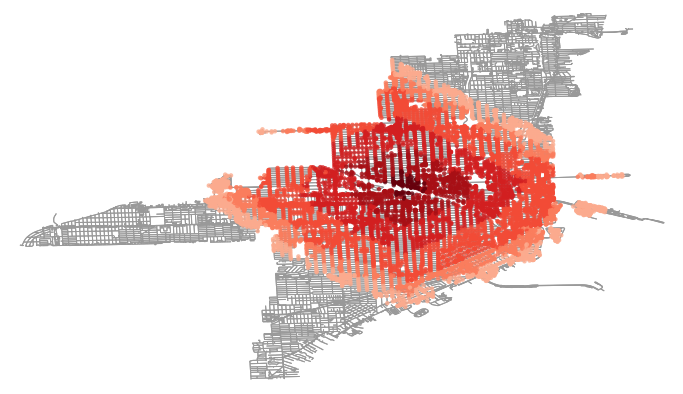

In [8]:
node_colors = {}

for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(Miami_streets, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in Miami_streets.nodes()]
ns = [20 if node in node_colors else 0 for node in Miami_streets.nodes()]
fig, ax = ox.plot_graph(Miami_streets, fig_height=7, fig_width=12, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [9]:
isochrone_polys = []

for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(Miami_streets, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

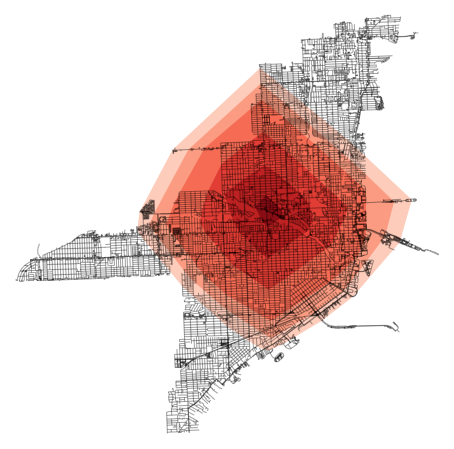

In [11]:
fig, ax = ox.plot_graph(Miami_streets, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
plt.show()